In [376]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.metrics import accuracy_score

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image
import matplotlib.image as mpimg

**1. Анализ дата сета**

In [377]:
from google.colab import drive 
drive.mount('/content/gdrive')
df=pd.read_csv('gdrive/MyDrive/GEEKBRAINS/Python_Libraries/Coursework/housing.csv')
df.head(5)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,1
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,2
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,3
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,4


In [378]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age    722
total_rooms             0
total_bedrooms        207
population            599
households              0
median_income           0
median_house_value      0
ocean_proximity         0
id                      0
dtype: int64

In [379]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,id
count,20640.000000,20640.000000,19918.000000,20640.000000,20433.000000,20041.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.471242,35.036934,28.653630,2635.763081,537.870553,1425.418243,499.539680,3.870671,206855.816909,10319.500000
std,5.041408,94.903955,12.576796,2181.615252,421.385070,1135.185798,382.329753,1.899822,115395.615874,5958.399114
min,-124.350000,-13534.030000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,786.000000,280.000000,2.563400,119600.000000,5159.750000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1165.000000,409.000000,3.534800,179700.000000,10319.500000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1726.000000,605.000000,4.743250,264725.000000,15479.250000
max,122.030000,1327.130000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,20639.000000


In [380]:
# Удаление выбросов

df = df.drop(df[df.median_house_value == 500001].index)
df = df.drop(df[df.latitude > 41.95].index)
df = df.drop(df[df.latitude < 32.54].index)
df = df.drop(df[df.longitude == 0].index)
df.loc[df['longitude'] > 0, 'longitude'] = df.loc[df['longitude'] > 0, 'longitude'] * -1
df.drop(['id'], axis=1, inplace=True)

In [381]:
# Корректировка значений

medians = df[['population', 'housing_median_age', 'total_bedrooms']].median()
df[['population', 'housing_median_age', 'total_bedrooms']] = df[['population', 'housing_median_age', 'total_bedrooms']].fillna(medians)
df['ocean_proximity'] = df['ocean_proximity'].replace(['-'],df['ocean_proximity'].mode())
df = pd.concat([df, pd.get_dummies(df['ocean_proximity'])], axis=1)

In [382]:
# Создание дополнительных признаков

longitude = df["longitude"].to_numpy()
latitude = df["latitude"].to_numpy()

San_Franciso_Proximity_O = np.absolute(longitude) - 122.41942 ### San-Francisco longitude
San_Franciso_Proximity_A = np.absolute(latitude) - 37.77493 ### San-Francisco latitude
San_Franciso_Proximity = np.sqrt(np.square(San_Franciso_Proximity_O) + np.square(San_Franciso_Proximity_A))
df['San_Franciso_Proximity'] = San_Franciso_Proximity.tolist()

Sacramento_Proximity_O = np.absolute(longitude) - 121.4944 ### Sacramento longitude
Sacramento_Proximity_A = np.absolute(latitude) - 38.58157 ### Sacramento latitude
Sacramento_Proximity = np.sqrt(np.square(Sacramento_Proximity_O) + np.square(Sacramento_Proximity_A))
df['Sacramento_Proximity'] = Sacramento_Proximity.tolist()

Fresno_Proximity_O = np.absolute(longitude) - 119.77237 ### Fresno longitude
Fresno_Proximity_A = np.absolute(latitude) - 36.74773 ### Fresno latitude
Fresno_Proximity = np.sqrt(np.square(Fresno_Proximity_O) + np.square(Fresno_Proximity_A))
df['Fresno_Proximity'] = Fresno_Proximity.tolist()

LA_Proximity_O = np.absolute(longitude) - 118.24368 ### Los-Angeles longitude
LA_Proximity_A = np.absolute(latitude) - 34.05223 ### Los-Angeles latitude
LA_Proximity = np.sqrt(np.square(LA_Proximity_O) + np.square(LA_Proximity_A))
df['LA_Proximity'] = LA_Proximity.tolist()

df['household_ratio'] = df['households'] / df['population']
df['bedroom_share'] = df['total_bedrooms'] / df['total_rooms'] * 100
df['population_per_room'] = df['population'] / df['total_rooms']

df['household_ratio'].fillna(value=df['household_ratio'].median(), inplace=True)
df['bedroom_share'].fillna(value=df['bedroom_share'].median(), inplace=True)
df['population_per_room'].fillna(value=df['population_per_room'].median(), inplace=True)

In [383]:
df.describe() # Проверка очищенного дата сета

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,San_Franciso_Proximity,Sacramento_Proximity,Fresno_Proximity,LA_Proximity,household_ratio,bedroom_share,population_per_room
count,19670.000000,19670.000000,19670.000000,19670.000000,19670.000000,19670.000000,19670.000000,19670.000000,19670.000000,19670.000000,19670.000000,19670.000000,19670.000000,19670.000000,19670.000000,19670.000000,19670.000000,19670.000000,19670.000000,19670.000000,19670.000000
mean,-119.562918,35.651567,28.387239,2619.525674,538.560244,1432.940061,501.153381,3.676535,192470.538688,0.438078,0.331113,0.000254,0.106457,0.124098,3.885553,3.904140,2.967834,2.666285,0.363464,21.576457,0.637415
std,2.006168,2.149833,12.279308,2180.991128,420.360369,1130.286476,383.227120,1.570133,97704.929955,0.496163,0.470626,0.015942,0.308429,0.329701,2.493416,2.391564,1.040919,2.415687,0.107320,6.466832,2.980237
min,-124.350000,32.540000,1.000000,2.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004964,0.004672,0.003282,0.004303,0.000804,3.723631,0.018109
25%,-121.760000,33.930000,18.000000,1438.000000,299.000000,806.000000,282.000000,2.526800,116600.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.224349,1.286652,2.462808,0.330759,0.301901,17.748601,0.443375
50%,-118.500000,34.270000,28.000000,2111.000000,436.000000,1177.000000,411.000000,3.450000,173800.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.250533,5.237379,3.038437,1.720814,0.352502,20.458115,0.523350
75%,-117.990000,37.730000,36.000000,3120.000000,645.000000,1721.000000,606.000000,4.582175,248200.000000,1.000000,1.000000,0.000000,0.000000,0.000000,5.853957,5.826767,3.426231,5.218721,0.410367,24.129930,0.670194
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.310086,9.036108,6.814004,9.865514,3.049278,283.116883,392.631579


In [384]:
df.isnull().sum() # Проверка очищенного дата сета

longitude                 0
latitude                  0
housing_median_age        0
total_rooms               0
total_bedrooms            0
population                0
households                0
median_income             0
median_house_value        0
ocean_proximity           0
<1H OCEAN                 0
INLAND                    0
ISLAND                    0
NEAR BAY                  0
NEAR OCEAN                0
San_Franciso_Proximity    0
Sacramento_Proximity      0
Fresno_Proximity          0
LA_Proximity              0
household_ratio           0
bedroom_share             0
population_per_room       0
dtype: int64

**2. Визуализация и разведка данных**

In [385]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [386]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 2.80 MB
Memory usage after optimization is: 1.74 MB
Decreased by 37.6%


In [387]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19670 entries, 0 to 20639
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   longitude               19670 non-null  float32 
 1   latitude                19670 non-null  float32 
 2   housing_median_age      19670 non-null  float32 
 3   total_rooms             19670 non-null  float32 
 4   total_bedrooms          19670 non-null  float32 
 5   population              19670 non-null  float32 
 6   households              19670 non-null  float32 
 7   median_income           19670 non-null  float32 
 8   median_house_value      19670 non-null  float32 
 9   ocean_proximity         19670 non-null  category
 10  <1H OCEAN               19670 non-null  float32 
 11  INLAND                  19670 non-null  float32 
 12  ISLAND                  19670 non-null  float32 
 13  NEAR BAY                19670 non-null  float32 
 14  NEAR OCEAN            

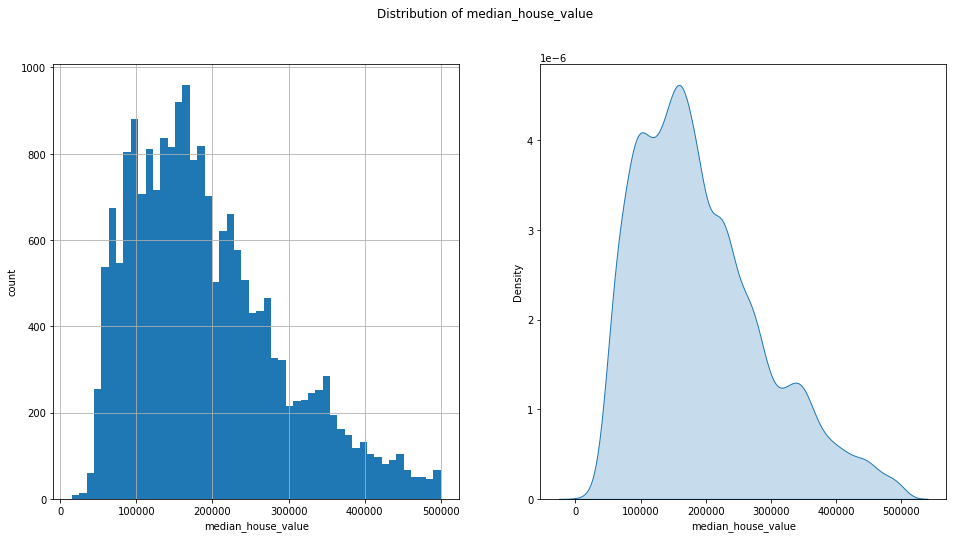

In [388]:
#Анализ целевой переменной
plt.figure(figsize = (16, 8))

plt.subplot(121)
df['median_house_value'].hist(density=False, bins=50)
plt.ylabel('count')
plt.xlabel('median_house_value')

plt.subplot(122)
sns.kdeplot(df['median_house_value'], shade=True, legend=False)
plt.xlabel('median_house_value')

plt.suptitle('Distribution of median_house_value')
plt.show()

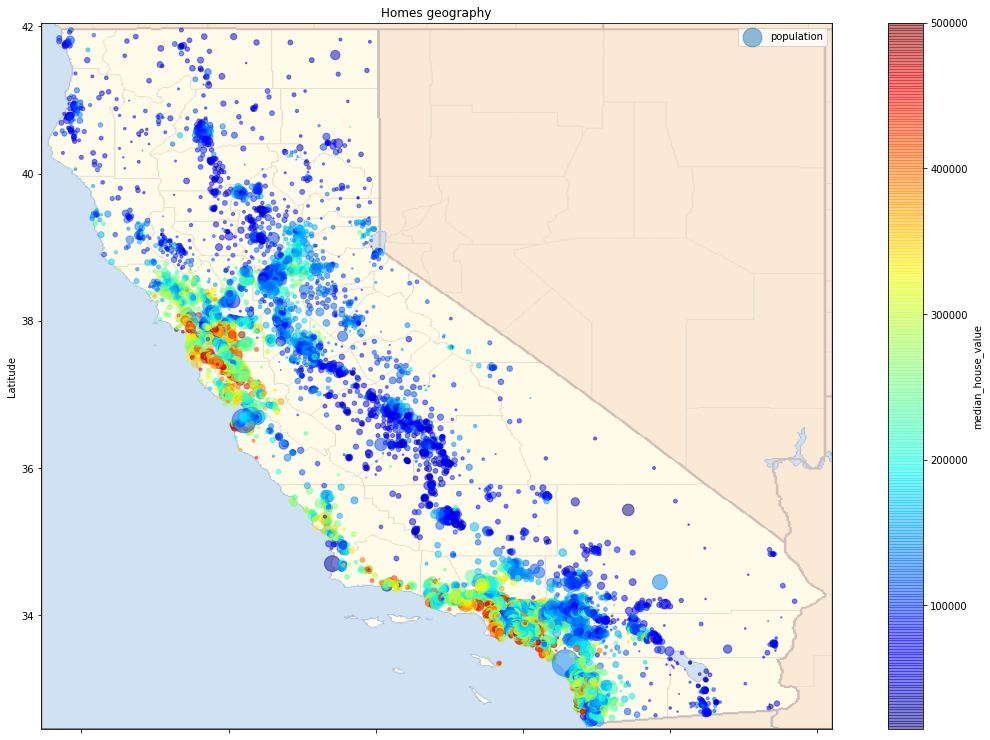

In [389]:
# Визуальный анализ географических данных

img = mpimg.imread('gdrive/MyDrive/GEEKBRAINS/Python_Libraries/califor.png')

df.plot(kind='scatter', x='longitude', y='latitude', alpha=0.5, 
        s=df['population'] / 50, label='population', c='median_house_value', 
        cmap=plt.get_cmap('jet'), figsize=(20,13))

imgplot = plt.imshow(img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Homes geography")
plt.legend() 
# plt.show()

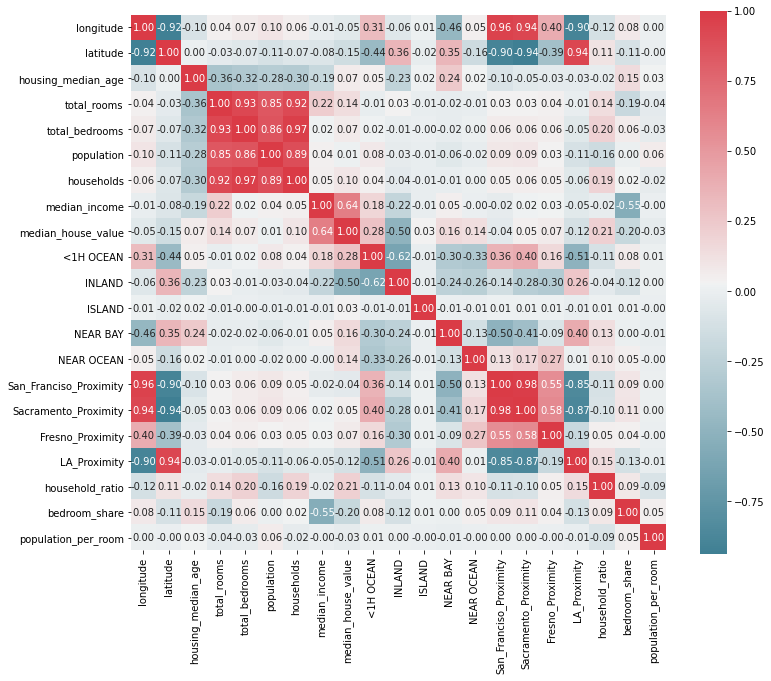

In [390]:
# Матрица корреляций для определения линейных зависимостей

f, ax = plt.subplots(figsize=(12, 10))
hcorr = df.corr()
sns.heatmap(hcorr, annot=True, fmt=".2f", mask=np.zeros_like(hcorr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

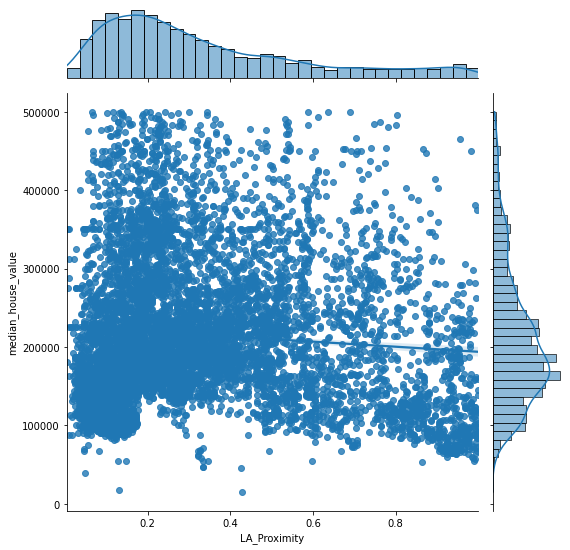

In [391]:
# Сравнение новых признаков с целевой переменной

df_cut = df[df['LA_Proximity'] <= 1]
grid = sns.jointplot(df_cut['LA_Proximity'], df_cut['median_house_value'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)
plt.show()

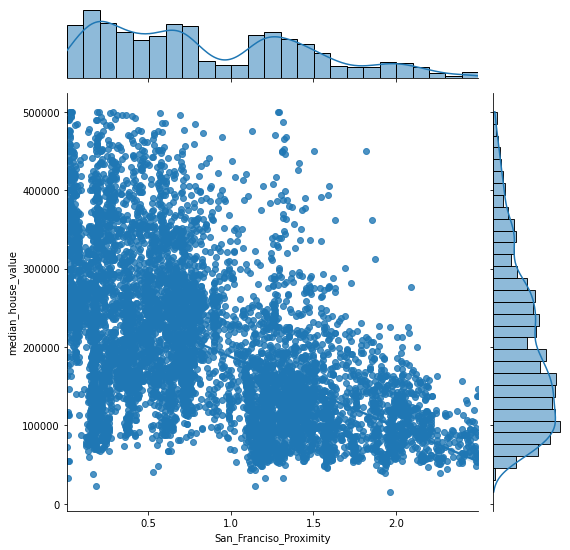

In [392]:
df_cut = df[df['San_Franciso_Proximity'] <= 2.5]
grid = sns.jointplot(df_cut['San_Franciso_Proximity'], df_cut['median_house_value'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)
plt.show()

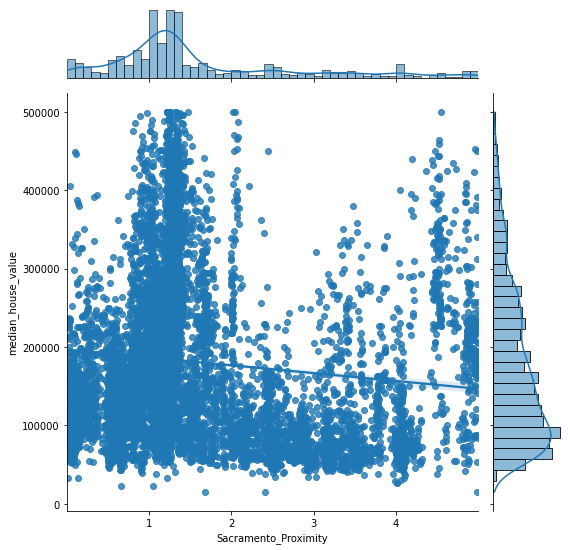

In [393]:
df_cut = df[df['Sacramento_Proximity'] <= 5]
grid = sns.jointplot(df_cut['Sacramento_Proximity'], df_cut['median_house_value'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)
plt.show()

**3. Предобработка данных**

In [394]:
df.columns.tolist()

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN',
 'San_Franciso_Proximity',
 'Sacramento_Proximity',
 'Fresno_Proximity',
 'LA_Proximity',
 'household_ratio',
 'bedroom_share',
 'population_per_room']

In [395]:
feature_names = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 
                 'households', 'median_income', '<1H OCEAN', 'INLAND', 'NEAR BAY', 'NEAR OCEAN', 'San_Franciso_Proximity', 'Sacramento_Proximity', 'Fresno_Proximity', 'Fresno_Proximity', 'LA_Proximity']

target_name = 'median_house_value'

In [396]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19670 entries, 0 to 20639
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   longitude               19670 non-null  float32 
 1   latitude                19670 non-null  float32 
 2   housing_median_age      19670 non-null  float32 
 3   total_rooms             19670 non-null  float32 
 4   total_bedrooms          19670 non-null  float32 
 5   population              19670 non-null  float32 
 6   households              19670 non-null  float32 
 7   median_income           19670 non-null  float32 
 8   median_house_value      19670 non-null  float32 
 9   ocean_proximity         19670 non-null  category
 10  <1H OCEAN               19670 non-null  float32 
 11  INLAND                  19670 non-null  float32 
 12  ISLAND                  19670 non-null  float32 
 13  NEAR BAY                19670 non-null  float32 
 14  NEAR OCEAN            

In [397]:
X = df[feature_names]
y = df[target_name]

In [410]:
# # Разбитие на тренироочную и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [411]:
# # Стандартизация признаков

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)

X_test_scaled = scaler.fit_transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

In [400]:
# Сохранение отмасштабированного дата сета в файл
# df.to_csv('PATH', index=False, encoding='utf-8', sep=';')

4. Обучение модели

In [401]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [413]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

y_test_preds = lr_model.predict(X_train)


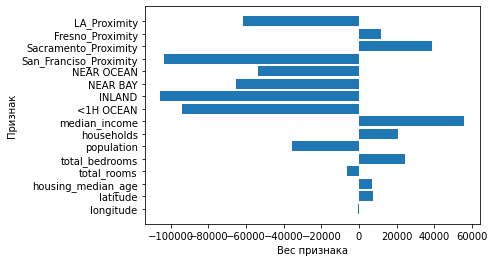

In [419]:
lr_model.fit(X_train_scaled, y_train)

plt.barh(feature_names, lr_model.coef_.flatten())

plt.xlabel("Вес признака")
plt.ylabel("Признак")

plt.show()

R2:	0.631
RMSE:	59117.156
MSE:	3494838000.0


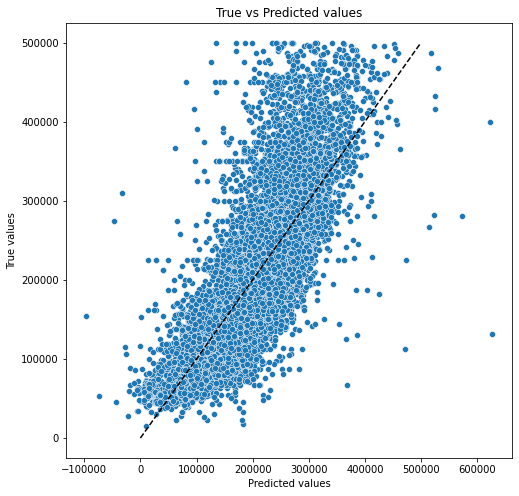

In [403]:
evaluate_preds(y_train, y_test_preds)

R2:	0.629
RMSE:	59911.273
MSE:	3589360590.419


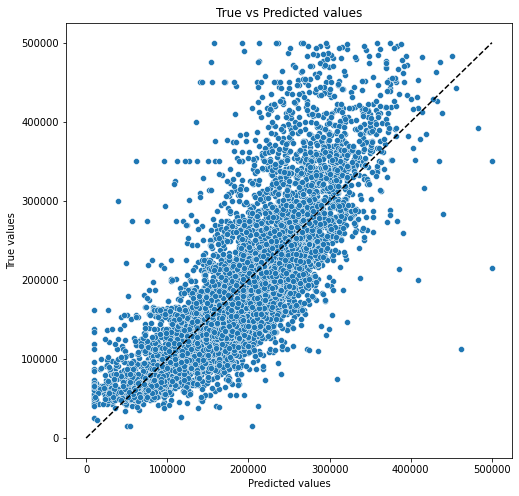

In [415]:
y_test_preds = lr_model.predict(X_test_scaled)

# Постпроцессинг
y_test_preds = np.clip(y_test_preds, a_min=10000, a_max=500000)

evaluate_preds(y_test, y_test_preds)

In [421]:
max_depth_values = np.arange(2, 14)

accuracy_on_valid = []
accuracy_on_train = []

for i, value in enumerate(max_depth_values):
    clf = DecisionTreeClassifier(max_depth=value)
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
        
    acc_valid = accuracy_score(y_test, y_pred)
    acc_train = accuracy_score(y_train, y_pred_train)
    
    if i % 4 == 0:
        print('K = {}'.format(value))
        print('\tacc_valid = {}'.format(acc_valid))
        print('\tacc_train = {}\n'.format(acc_train))
    
    accuracy_on_valid.append(acc_valid)
    accuracy_on_train.append(acc_train)

K = 2
	acc_valid = 0.004929143561306223
	acc_train = 0.00766428896645925

K = 6
	acc_valid = 0.006007393715341959
	acc_train = 0.018515707998178782

K = 10
	acc_valid = 0.0038508934072704866
	acc_train = 0.0558506601912278



R2:	1.0
RMSE:	0.0
MSE:	0.0


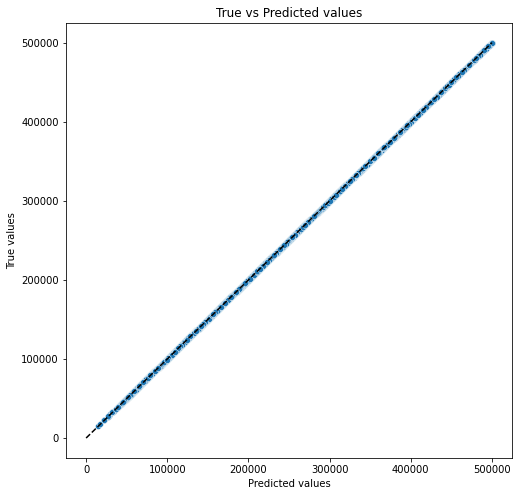

In [436]:
dt_model = DecisionTreeRegressor(criterion='mse', 
                                 max_depth=400, # глубина дерева  
                                 min_samples_leaf=1, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42)
dt_model.fit(X_train, y_train)

y_train_preds = dt_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.637
RMSE:	59253.45
MSE:	3510971379.052


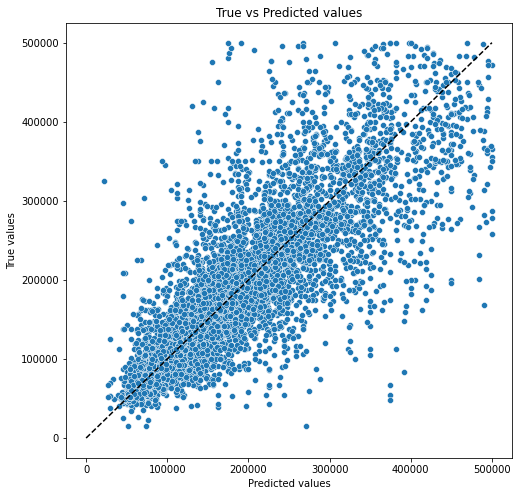

In [437]:
y_test_preds = dt_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

R2:	0.789
RMSE:	44774.06
MSE:	2004716423.789


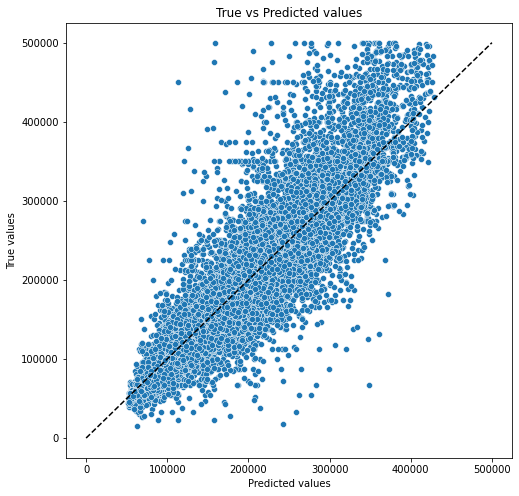

In [438]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=20, # глубина дерева  
                                 min_samples_leaf=30, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42,
                                 n_estimators=100  # кол-во деревьев
                                 )

rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.749
RMSE:	49245.775
MSE:	2425146328.553


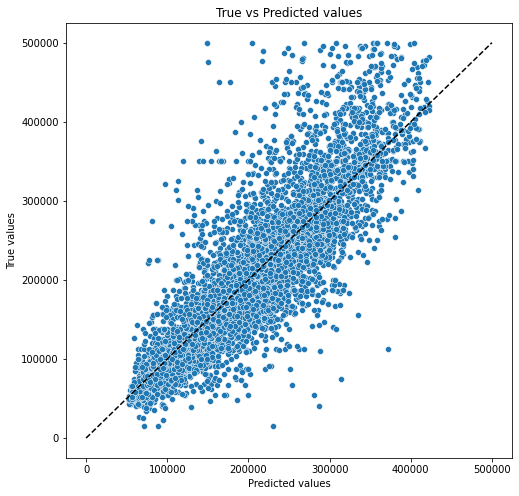

In [439]:
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

R2:	0.901
RMSE:	30582.057
MSE:	935262208.321


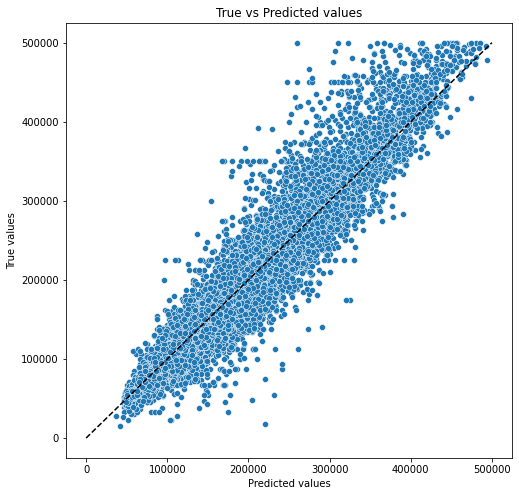

In [440]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=100)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.808
RMSE:	43116.331
MSE:	1859018041.433


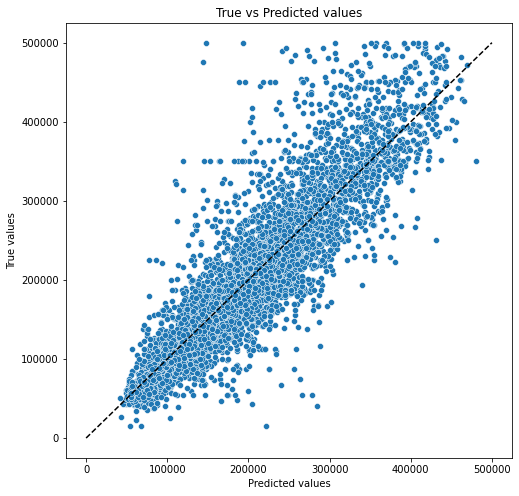

In [441]:
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

**5. Оценка модели**

In [444]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=7,
                                        min_samples_leaf=10,
                                        random_state=42,
                                        n_estimators=400)

final_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=7,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=400,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

R2:	0.959
RMSE:	19675.857
MSE:	387139360.686


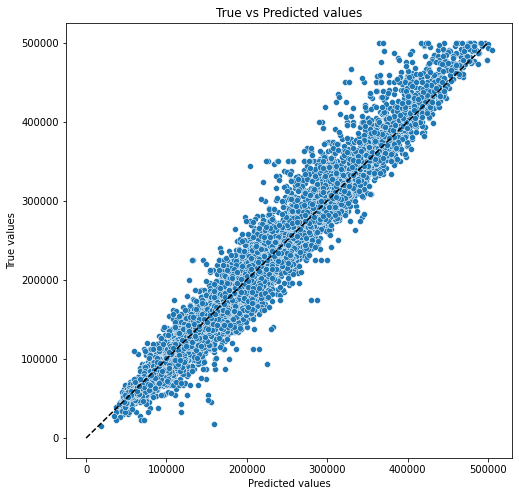

In [445]:
y_train_preds = final_model.predict(X_train)
evaluate_preds(np.squeeze(y_train.values), y_train_preds)

R2:	0.818
RMSE:	42003.812
MSE:	1764320217.955


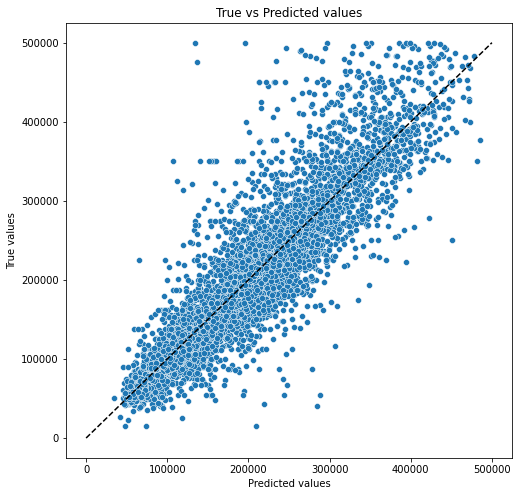

In [448]:
y_test_preds = final_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [449]:
final_model.feature_importances_

array([4.30108637e-02, 4.40217450e-02, 3.03416112e-02, 2.12767775e-02,
       2.04014567e-02, 2.88289504e-02, 1.37138088e-02, 4.23761147e-01,
       4.24260718e-03, 1.62738594e-01, 3.86071159e-04, 6.75446597e-03,
       3.69845881e-02, 4.80083008e-02, 2.42953833e-02, 4.10063943e-02,
       5.02272345e-02])

In [451]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [452]:
feature_importances.head(3)

,feature_name,importance
7,median_income,0.423761
9,INLAND,0.162739
16,LA_Proximity,0.050227


In [453]:
feature_importances.tail(3)

,feature_name,importance
11,NEAR OCEAN,0.006754
8,<1H OCEAN,0.004243
10,NEAR BAY,0.000386
